# Langgraph with AgentNeo Integration
 This Jupyter notebook demonstrates the integration of AgentNeo, a powerful tracing and monitoring tool, with Langgraph, a graph-based approach to managing language models with an agent-based system to enhance the automation and decision-making capabilities of your application. This integration allows for comprehensive analysis and debugging of AI-powered systems.

 # Setup and Imports
First, let's import the necessary libraries and set up our environment.

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:

import os
import uuid
from dotenv import load_dotenv
from typing import List, Literal, Annotated
from typing_extensions import TypedDict
import openai

from langchain_core.messages import (
    SystemMessage, 
    HumanMessage, 
    AIMessage, 
    ToolMessage
)
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages


# Load environment variables from .env file
load_dotenv()

# Initialize OpenAI API using environment variables
openai.api_key = os.getenv("OPENAI_API_KEY")



 # Initialize AgentNeo Session and Tracer
 Now, let's set up our AgentNeo session and tracer.



In [3]:
from agentneo import AgentNeo, Tracer, Execution


# Initialize AgentNeo session
neo_session = AgentNeo(session_name="recipe_builder_assistant")
try:
    neo_session.create_project(project_name="Study_Guide")
except:
    neo_session.connect_project(project_name="Study_Guide")

# Create tracer
tracer = Tracer(session=neo_session)
tracer.start()

INFO:httpx:HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


Project 'Study_Guide' found.
Tracing Started.



 # Define Agents and Tools
Now, let's create our AI tools using langgraph.

In [4]:
# Define Agents and Tools

@tracer.trace_agent(name="StudyPlan")
class StudyPlan(BaseModel):
    """Study plan for data science topics."""
    topic: str
    duration: str
    key_concepts: List[str]

@tracer.trace_agent(name="StudyPlannerAgent")
class StudyPlannerAgent:
    def __init__(self):
        self.template = """You are a helpful data science study planner. Your job is to create structured study plans for various data science topics.

Given a data science topic:
1. Break down the topic into 3-5 key concepts or sub-topics
2. Suggest a realistic time allocation for each sub-topic
3. Recommend a total study duration"""

        self.llm = ChatOpenAI(temperature=0.7)
        self.llm_with_tool = self.llm.bind_tools([StudyPlan])

    @tracer.trace_tool(name="study_plan_chain")
    def study_plan_chain(self, state):
        messages = [SystemMessage(content=self.template)] + state["messages"]
        response = self.llm_with_tool.invoke(messages)
        return {"messages": [response]}


In [5]:
@tracer.trace_agent(name="ConceptExplainerAgent")
class ConceptExplainerAgent:
    def __init__(self):
        self.template = """You are a data science concept explainer. Your job is to provide clear explanations of data science concepts and theories.

Given a data science concept:
1. Provide a concise definition
2. Explain the concept's importance in data science
3. Give a practical example or use case"""

        self.llm = ChatOpenAI(temperature=0.3)

    @tracer.trace_tool(name="concept_explanation_chain")
    def concept_explanation_chain(self, state):
        messages = [SystemMessage(content=self.template)] + state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}



In [6]:
@tracer.trace_agent(name="PracticalExerciseGenerator")
class PracticalExerciseGenerator:
    def __init__(self):
        self.template = """You are a practical exercise generator for data science topics. Your job is to create hands-on coding exercises or data analysis tasks.

Given a data science concept or topic:
1. Create a practical exercise that reinforces the concept
2. Provide a clear problem statement
3. Offer hints or tips for approaching the problem"""

        self.llm = ChatOpenAI(temperature=0.7)

    @tracer.trace_tool(name="generate_exercise_chain")
    def generate_exercise_chain(self, state):
        messages = [SystemMessage(content=self.template)] + state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}

In [7]:
@tracer.trace_agent(name="ResourceRecommenderAgent")
class ResourceRecommenderAgent:
    def __init__(self):
        self.template = """You are a resource recommender for data science topics. Your job is to suggest relevant learning materials.

Given a data science topic or concept:
1. Recommend 2-3 books (with authors) relevant to the topic
2. Suggest 1-2 online courses or MOOCs
3. Provide links to 2-3 high-quality tutorials or articles"""

        self.llm = ChatOpenAI(temperature=0.5)

    @tracer.trace_tool(name="recommend_resources_chain")
    def recommend_resources_chain(self, state):
        messages = [SystemMessage(content=self.template)] + state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}

# Managing state graphs, saving memory, handling messages, and typing annotations.

In [8]:
# State management

@tracer.trace_tool(name="get_state")
def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif isinstance(messages[-1], AIMessage):
        if "study plan" in messages[-1].content.lower():
            return "concept_explanation"
        elif "concept" in messages[-1].content.lower():
            return "practical_exercise"
        elif "exercise" in messages[-1].content.lower():
            return "recommend_resources"
        else:
            return END
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "study_planning"

@tracer.trace_agent(name="State")
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize workflow
memory = MemorySaver()
workflow = StateGraph(State)

# Initialize agents
study_planner = StudyPlannerAgent()
concept_explainer = ConceptExplainerAgent()
exercise_generator = PracticalExerciseGenerator()
resource_recommender = ResourceRecommenderAgent()

# Add nodes to workflow
workflow.add_node("study_planning", study_planner.study_plan_chain)
workflow.add_node("concept_explanation", concept_explainer.concept_explanation_chain)
workflow.add_node("practical_exercise", exercise_generator.generate_exercise_chain)
workflow.add_node("recommend_resources", resource_recommender.recommend_resources_chain)

@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Study plan generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

# Add edges to workflow
workflow.add_conditional_edges(
    "study_planning",
    get_state,
    ["add_tool_message", "concept_explanation", "practical_exercise", "recommend_resources", END]
)
workflow.add_edge("add_tool_message", "concept_explanation")
workflow.add_edge("concept_explanation", "practical_exercise")
workflow.add_edge("practical_exercise", "recommend_resources")
workflow.add_edge("recommend_resources", END)
workflow.add_edge(START, "study_planning")

# Compile graph
graph = workflow.compile(checkpointer=memory)

# Displaying a PNG image of a graph generated from a LangGraph instance using Mermaid visualization

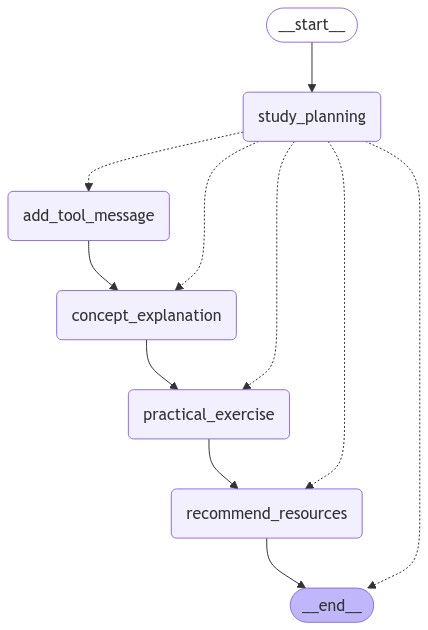

In [9]:
# %% 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Main interaction loop
def run_interaction():
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    print("Welcome to the Simplified Data Science Study Assistant!")
    print("You can ask for a study plan, concept explanations, practical exercises, or resource recommendations.")
    print("Type 'q' or 'quit' to exit.")

    while True:
        user = input("\nWhat would you like help with? ")
        
        if user.lower() in {"q", "quit"}:
            print("Thank you for using the Data Science Study Assistant! Good luck with your studies!")
            break
            
        output = None
        for output in graph.stream(
            {"messages": [HumanMessage(content=user)]}, 
            config=config, 
            stream_mode="updates"
        ):
            last_message = next(iter(output.values()))["messages"][-1]
            last_message.pretty_print()

        if output and "recommend_resources" in output:
            print("\nStudy plan, concept explanation, practical exercise, and resource recommendations completed!")
            print("Is there anything else you'd like to know?")



# Metrics Evaluation System

In [11]:

# Metrics Evaluation System
def execute_metrics(neo_session, trace_id):
    """Execute and return metrics analysis."""
    exe = Execution(session=neo_session, trace_id=trace_id)
    exe.execute(metric_list=[
        'goal_decomposition_efficiency',
        'goal_fulfillment_rate',
        'tool_call_success_rate_metric'
    ])
    return exe.get_results()

def print_metrics_results(metric_results):
    """Print the metrics results in a formatted way."""
    print("\nMetrics Results:")
    print(metric_results)

def launch_metrics_dashboard(neo_session):
    """Launch the AgentNeo metrics dashboard."""
    neo_session.launch_dashboard()

In [12]:
if __name__ == "__main__":
    try:
        run_interaction()
    finally:
        tracer.stop()
        print(f"Trace ID: {tracer.trace_id}")
        


Welcome to the Simplified Data Science Study Assistant!
You can ask for a study plan, concept explanations, practical exercises, or resource recommendations.
Type 'q' or 'quit' to exit.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  StudyPlan (call_Mk2pKihAhBPhrTFexjWHyd0I)
 Call ID: call_Mk2pKihAhBPhrTFexjWHyd0I
  Args:
    topic: Machine Learning
    duration: 4 weeks
    key_concepts: ['Introduction to Machine Learning', 'Supervised Learning', 'Unsupervised Learning', 'Model Evaluation and Selection', 'Feature Engineering']
================================= Tool Message =================================

Study plan generated!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

That's great to hear that you want to study machine learning for 4 weeks! Machine learning is a fundamental concept in data science. Here is a brief overview of some key concepts you might cover during your study:

1. **Introduction to Machine Learning**:
   - **Definition**: Machine learning is a field of artificial intelligence that focuses on developing algorithms and statistical models to enable computers to learn from and make predictions or decisions based on data.
   - **Importance**: Understanding the basics of machine learning is crucial for anyone looking to work with data as it allows you to build predictive models, uncover patterns in data, and make data-driven decisions.

2. **Supervised Learning**:
   - **Definition**: Supervised learning is a type of machine learning where the model is trained on labeled data, and it learns to map input data to the correct output.
   - **Importance**: Super

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here is a practical exercise to reinforce your understanding of supervised learning:

**Problem Statement:**
You are given a dataset containing information about housing prices. Your task is to build a supervised machine learning model to predict the price of a house based on its features such as size, number of bedrooms, location, etc.

**Hints:**
1. Start by loading and exploring the dataset to understand the features and the target variable (price).
2. Preprocess the data by handling missing values, encoding categorical variables, and scaling numerical features if necessary.
3. Split the dataset into training and testing sets to train and evaluate your model.
4. Choose a supervised learning algorithm (e.g., linear regression, decision tree, random forest) to build your predictive model.
5. Train the model on the training data and evaluate its performance using metrics like mean squared error or R-squar

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

To deepen your understanding of machine learning, here are some recommended resources:

### Books:
1. **"Introduction to Machine Learning with Python: A Guide for Data Scientists"** by Andreas C. Müller and Sarah Guido
   - This book provides a practical introduction to machine learning using Python. It covers essential concepts, techniques, and tools for building machine learning models.

2. **"Pattern Recognition and Machine Learning"** by Christopher M. Bishop
   - This comprehensive book covers the fundamental concepts of pattern recognition and machine learning. It delves into topics like Bayesian methods, neural networks, and kernel methods.

### Online Courses:
1. **Machine Learning by Stanford University on Coursera**
   - This course by Andrew Ng is a popular choice for beginners in machine learning. It covers a wide range of topics including supervised learning, unsupervised learning, and deep l

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  StudyPlan (call_UpukcFRB4lAYW8stqJe4vCoZ)
 Call ID: call_UpukcFRB4lAYW8stqJe4vCoZ
  Args:
    topic: Generative AI
    duration: 4 weeks
    key_concepts: ['Generative Adversarial Networks (GANs)', 'Variational Autoencoders (VAEs)', 'Recurrent Neural Networks (RNNs) for Sequence Generation', 'Transformer Models', 'Applications of Generative AI']
================================= Tool Message =================================

Study plan generated!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here is a breakdown of key concepts related to Generative AI that you can study over the next 4 weeks:

1. **Generative Adversarial Networks (GANs)**:
   - **Definition**: GANs are a class of neural networks that are used to generate new data samples that resemble a given dataset. They consist of two networks - a generator and a discriminator - that are trained adversarially.
   - **Importance**: GANs have revolutionized the field of generative modeling by enabling the creation of realistic images, videos, and other data types. They are widely used in image synthesis, style transfer, and data augmentation.

2. **Variational Autoencoders (VAEs)**:
   - **Definition**: VAEs are generative models that learn to encode and decode data into a latent space. They are trained to reconstruct input data while also generating new samples by sampling from the learned latent space.
   - **Importance**: VAEs are valuabl

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here is a practical exercise to reinforce your understanding of Generative Adversarial Networks (GANs):

**Problem Statement:**
You are tasked with creating a GAN model to generate realistic images of handwritten digits (0-9) from the MNIST dataset. The generator network should learn to create new digit images that closely resemble the original dataset, while the discriminator network should distinguish between real and generated images.

**Hints:**
1. Load the MNIST dataset containing images of handwritten digits and preprocess the data.
2. Design the architecture of the generator and discriminator networks. The generator should generate fake images, while the discriminator should classify between real and fake images.
3. Train the GAN model in an adversarial manner: the generator tries to fool the discriminator, and the discriminator tries to differentiate between real and fake images.
4. Monitor the tr

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

To deepen your understanding of Generative AI, here are some recommended resources:

### Books:
1. **"Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play"** by David Foster
   - This book provides a comprehensive overview of generative models in deep learning, covering topics like GANs, VAEs, and autoregressive models. It includes practical examples and code implementations to help you understand and apply generative techniques.

2. **"Deep Learning for Computer Vision: Expert techniques to train advanced neural networks using TensorFlow and Keras"** by Rajalingappaa Shanmugamani
   - While not solely focused on generative AI, this book covers deep learning concepts relevant to computer vision tasks, including generative models. It can help you understand how generative models are applied in image generation and other computer vision applications.

### Online Courses:
1. **"Gene

In [13]:
results = execute_metrics(neo_session, tracer.trace_id)


11:36:39 - LiteLLM:INFO: utils.py:2686 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:37:26 - LiteLLM:INFO: utils.py:937 - Wrapper: Completed Call, calling success_handler
INFO:LiteLLM:Wrapper: Completed Call, calling success_handler
11:37:26 - LiteLLM:INFO: utils.py:2686 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:38:15 - LiteLLM:INFO: utils.py:937 - Wrapper: Completed Call, calling success_handler
INFO:LiteLLM:Wrapper: Completed Call, calling success_handler
11:38:15 - LiteLLM:INFO: utils.py:2686 - 
LiteLLM completion() model= gpt-4o-mini; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o-mini; provider = o

In [14]:
# Display results
print_metrics_results(results)
        



Metrics Results:
[{'metric_name': 'goal_decomposition_efficiency', 'score': 0.85, 'reason': "The decomposition effectively breaks down the original goal into clear and actionable sub-tasks that cover all aspects of the study plan. Each sub-task is logically sequenced and addresses specific components of the learning process, such as key concepts, practical exercises, and resource recommendations. However, while the tasks are well-defined, the allocation of time for each concept could be more explicitly detailed to enhance granularity. Overall, the decomposition is efficient and aligns well with the user's goal.", 'result_detail': {'metric_name': 'goal_fulfillment_rate', 'config': {}, 'result': {'originalGoal': 'Create a structured study plan for learning machine learning over a duration of four weeks.', 'subtasks': ['Create a study plan for Machine Learning covering the following key concepts: Introduction to Machine Learning, Supervised Learning, Unsupervised Learning, Model Evaluati

In [15]:
results

[{'metric_name': 'goal_decomposition_efficiency',
  'score': 0.85,
  'reason': "The decomposition effectively breaks down the original goal into clear and actionable sub-tasks that cover all aspects of the study plan. Each sub-task is logically sequenced and addresses specific components of the learning process, such as key concepts, practical exercises, and resource recommendations. However, while the tasks are well-defined, the allocation of time for each concept could be more explicitly detailed to enhance granularity. Overall, the decomposition is efficient and aligns well with the user's goal.",
  'result_detail': {'metric_name': 'goal_fulfillment_rate',
   'config': {},
   'result': {'originalGoal': 'Create a structured study plan for learning machine learning over a duration of four weeks.',
    'subtasks': ['Create a study plan for Machine Learning covering the following key concepts: Introduction to Machine Learning, Supervised Learning, Unsupervised Learning, Model Evaluation

In [16]:
# Launch dashboard
launch_metrics_dashboard(neo_session)

INFO:root:Dashboard launched successfully. Access it at: http://localhost:3000
